In [7]:
import qiskit

In [8]:
qiskit.__version__

'1.1.1'

In [9]:
from qiskit_ibm_runtime import QiskitRuntimeService
from config import TOKEN
service = QiskitRuntimeService(channel='ibm_quantum', token=TOKEN)

In [10]:
backend = service.backend(name = "ibm_brisbane")
backend.num_qubits

127

# Hello world example on a 2-qubit Bell state

## Step 1: Map the problem to circuits and operators

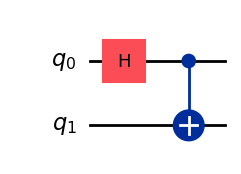

In [11]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(2)

qc.h(0)
qc.cx(0, 1)

qc.draw(output="mpl")

In [12]:
from qiskit.quantum_info import Pauli

ZZ = Pauli("ZZ")
ZI = Pauli("ZI")
IZ = Pauli("IZ")
XX = Pauli("XX")
XI = Pauli("XI")
IX = Pauli("IX")

observables = (ZZ, ZI, IZ, XX, XI, IX)

## Step 2: Optimize

## Step 3: Execute on the backend

In [13]:
from qiskit_aer.primitives import Estimator

estimator = Estimator()

job = estimator.run([qc] * len(observables), observables)

job.result()

EstimatorResult(values=array([ 1.        , -0.01367188, -0.01367188,  1.        ,  0.00585938,
        0.00585938]), metadata=[{'shots': 1024, 'variance': 0.0, 'simulator_metadata': [{'batched_shots_optimization': False, 'required_memory_mb': 0, 'method': 'stabilizer', 'active_input_qubits': [0, 1], 'device': 'CPU', 'remapped_qubits': False, 'num_qubits': 2, 'num_clbits': 2, 'time_taken': 0.006494, 'sample_measure_time': 0.0015224, 'input_qubit_map': [[0, 0], [1, 1]], 'max_memory_mb': 15741, 'measure_sampling': True, 'noise': 'ideal', 'parallel_shots': 1, 'parallel_state_update': 8, 'runtime_parameter_bind': False, 'num_bind_params': 1, 'fusion': {'enabled': False}}]}, {'shots': 1024, 'variance': 0.9998130798339844, 'simulator_metadata': [{'batched_shots_optimization': False, 'required_memory_mb': 0, 'method': 'stabilizer', 'active_input_qubits': [0, 1], 'device': 'CPU', 'remapped_qubits': False, 'num_qubits': 2, 'num_clbits': 2, 'time_taken': 0.006494, 'sample_measure_time': 0.0015224

## Step 4: Post-processing (and plotting)

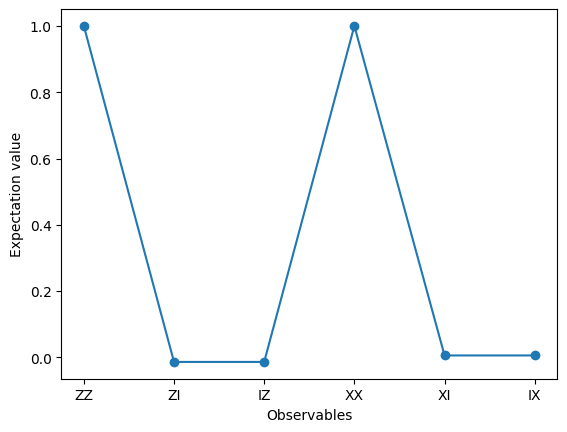

In [14]:
import matplotlib.pyplot as plt

data = ["ZZ", "ZI", "IZ", "XX", "XI", "IX"]
values = job.result().values
plt.plot(data, values, "-o")
plt.xlabel("Observables")
plt.ylabel("Expectation value")
plt.show()

# Extend the Hello World example to an n-qbit GHZ state

## Step 1: Map the problem to circuits and operators

In [15]:
def get_qc_for_n_qbit_GHZ_state(n):
    qc = QuantumCircuit(n)
    qc.h(0)
    for i in range(n - 1):
        qc.cx(i, i+1)
    return qc

n = 100
qc = get_qc_for_n_qbit_GHZ_state(n)
#qc.draw(output="mpl")


In [16]:
from qiskit.quantum_info import SparsePauliOp

operator_strings = [f"Z{'I' * i}Z{'I' * (n - 2 - i)}" for i in range(n - 1)]
print(operator_strings)
print(len(operator_strings))

operators = [SparsePauliOp(ostr) for ostr in operator_strings]

['ZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII

## Step 2: Optimize the problem for quantum execution

In [17]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pass_manager = generate_preset_pass_manager(optimization_level=1, backend=backend)

qc_transpiled = pass_manager.run(qc)
operators_transpiled = [op.apply_layout(qc_transpiled.layout) for op in operators]

## Step 3: Execute on the backend

In [18]:
from qiskit_ibm_runtime import EstimatorV2 as Estimator, EstimatorOptions

options = EstimatorOptions()
options.resilience_level = 1
options.optimization_level = 0
options.dynamical_decoupling.enable = True
options.dynamical_decoupling.sequence_type = "XY4"

estimator = Estimator(backend, options=options)
job = estimator.run([(qc_transpiled, operators_transpiled)])
job_id = job.job_id()
print(job_id)


csxkqzqfhyd0008ka4ag


## Step 4: Post-processing and plotting

In [19]:
job = service.job('csxf05rvkv50008hrtjg')
job_result = job.result()

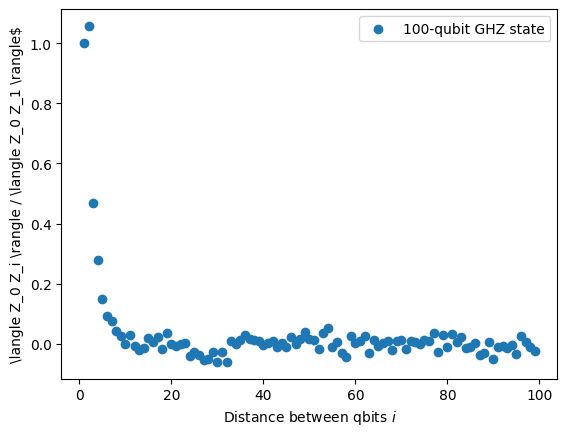

In [20]:
import matplotlib.pyplot as plt

data = list(range(1, len(operators) + 1))
result = job_result[0]
values = result.data.evs
values = [v / values[0] for v in values]

plt.scatter(data, values, marker="o", label="100-qubit GHZ state")
plt.xlabel("Distance between qbits $i$")
plt.ylabel(r"\langle Z_0 Z_i \rangle / \langle Z_0 Z_1 \rangle$")
plt.legend()
plt.show()